In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)

In [3]:
setwd("/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/phyloseq/")

otu <- read.csv(file="/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/phyloseq/final/OTU_X.csv",header=TRUE)
#head(otu)
tax <- read.table(file="taxonomy.tsv",sep='\t',header=TRUE)
#head(tax)
merged_file <- merge(otu,tax,by.x=c("OTUID"),by.y=c("OTUID"))
#head(merged_file)
write.table(merged_file, file="combined_otu_tax.txt",sep='\t',col.names=TRUE,row.names=FALSE)

#Export and separate into OTU and taxonomy tables (see qiime2_to_phyloseq.pdf)

otu_table=read.csv("OTU_table.csv",sep=",",row.names=1)
otu_table = as.matrix(otu_table)
taxonomy= read.csv("tax_table.csv",sep=",",row.names=1)
taxonomy=as.matrix(taxonomy)

OTU=otu_table(otu_table,taxa_are_rows=TRUE)
TAX=tax_table(taxonomy)

OTU=otu_table(otu_table,taxa_are_rows=TRUE)
TAX=tax_table(taxonomy)

META=import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/phyloseq/final/META_X.txt")
tree=read_tree("rep_phylo_tree.nwk")

ps = merge_phyloseq(OTU,TAX,META,tree)
ps


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 729 taxa and 96 samples ]
sample_data() Sample Data:       [ 96 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 729 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 729 tips and 723 internal nodes ]

In [5]:
alz_nt <- prune_samples(sample_sums(ps) > 1000, ps)
alz_t <- merge_phyloseq(OTU,TAX,META,tree) %>%
    prune_samples((sample_sums(.) > 1000), .) %>%
    filter_taxa(function(x) sum(x > 3) > (0.001*length(x)), TRUE) %>%
    transform_sample_counts(function(x) x / sum(x))

saveRDS(alz_nt, "/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/PS_for_analysis/alz_nt.rds")
saveRDS(alz_t, "/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/PS_for_analysis/alz_t.rds")

In [2]:
#Read in NEW DATA NOVEMBER 2019
alz_nt = readRDS("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/PS_for_analysis/alz_nt.rds")
alz_t = readRDS("/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/PS_for_analysis/alz_t.rds")

In [8]:
otu = data.frame(sample_data(alz_nt))
write.csv(otu, "/projects/gilbert_lab/Lutz/Alzheimers/Update_Oct2019/PS_for_analysis/alz_nt.metadata.csv")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


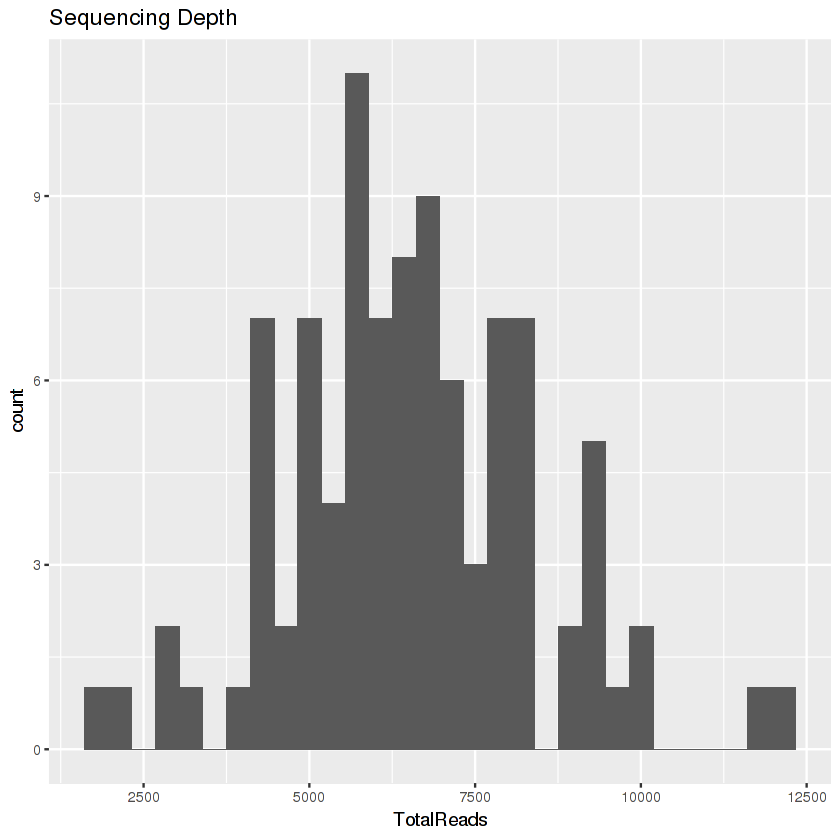

In [81]:
alz_sdt = data.table(as(sample_data(alz_nt), "data.frame"),
                 TotalReads = sample_sums(alz_nt), keep.rownames = TRUE)
setnames(alz_sdt, "rn", "SampleName")
pSeqDepth = ggplot(alz_sdt, aes(TotalReads)) + geom_histogram() + ggtitle("Sequencing Depth")
pSeqDepth


In [8]:
sample_tab = data.frame(sample_data(alz_nt))
names(sample_tab) <- c("SampleID", "BarcodeSequence", "LinkerPrimerSequence", "PrimerPlate", "PrimerWell", "Tube", "MouseTag", "SampleType", "Sex", "Treatment", "FecalMassGm","Description")
head(sample_tab)

,SampleID,BarcodeSequence,LinkerPrimerSequence,PrimerPlate,PrimerWell,Tube,MouseTag,SampleType,Sex,Treatment,FecalMassGm,Description
X17,X17,GCATATGCACTG,GTGTGYCAGCMGCCGCGGTAA,D5,ABX_cecal_plate1,3046,M,Cecal,Abx_FMT,M_Abx_FMT,0.0493,M17
X5.F.7.Abx,X5.F.7.Abx,AATAACTAGGGT,GTGTGYCAGCMGCCGCGGTAA,D11,ABX_fecal_plate2,unknown,F,Fecal,Abx,F_Abx,Unknown,5.F.7.Abx
X2.M.1.Abx,X2.M.1.Abx,ACTACTGAGGAT,GTGTGYCAGCMGCCGCGGTAA,A11,ABX_fecal_plate2,unknown,M,Fecal,Abx,M_Abx,Unknown,2.M.1.Abx
X9,X9,CATTTCGCACTT,GTGTGYCAGCMGCCGCGGTAA,C9,ABX_cecal_plate1,3190,M,Cecal,Control,M_Control,0.0299,M9
X4.F.7.ctr,X4.F.7.ctr,ACCTTACACCTT,GTGTGYCAGCMGCCGCGGTAA,D2,ABX_fecal_plate2,unknown,F,Fecal,Control,F_Control,Unknown,4.F.7.ctr
X4.F.1.Ctr,X4.F.1.Ctr,AAGAACTCATGA,GTGTGYCAGCMGCCGCGGTAA,C6,ABX_fecal_plate2,unknown,F,Fecal,Control,F_Control,Unknown,4.F.1.Ctr


In [4]:
alz_nt_fecal = subset_samples(alz_nt, SampleType=="Fecal")
alz_nt_cecal = subset_samples(alz_nt, SampleType=="Cecal")

alz_nt_fec_M = subset_samples(alz_nt_fecal, Sex=="M")
alz_nt_fec_F = subset_samples(alz_nt_fecal, Sex=="F")
alz_nt_cec_M = subset_samples(alz_nt_cecal, Sex=="M")
alz_nt_cec_F = subset_samples(alz_nt_cecal, Sex=="F")

In [9]:
fecal.obs = estimate_richness(na.omit(alz_nt_fecal), split = TRUE, measures = "Observed")
fecal.obs$SampleID = rownames(fecal.obs)
fecal.obs = merge(fecal.obs, sample_tab, on="SampleID")

cecal.obs = estimate_richness(na.omit(alz_nt_cecal), split = TRUE, measures = "Observed")
cecal.obs$SampleID = rownames(cecal.obs)
cecal.obs = merge(cecal.obs, sample_tab, on="SampleID")

fecal.sha = estimate_richness(na.omit(alz_nt_fecal), split = TRUE, measures = "Shannon")
fecal.sha$SampleID = rownames(fecal.sha)
fecal.sha = merge(fecal.sha, sample_tab, on="SampleID")

cecal.sha = estimate_richness(na.omit(alz_nt_cecal), split = TRUE, measures = "Shannon")
cecal.sha$SampleID = rownames(cecal.sha)
cecal.sha = merge(cecal.sha, sample_tab, on="SampleID")

write.csv(fecal.obs, "/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/data_for_Hemraj/fecal.observed.csv")
write.csv(cecal.obs, "/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/data_for_Hemraj/cecal.observed.csv")
write.csv(fecal.sha, "/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/data_for_Hemraj/fecal.shannon.csv")
write.csv(cecal.sha, "/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/data_for_Hemraj/cecal.shannon.csv")


In [7]:
#Observed richness by treatment group - MALES - FECAL

obs = estimate_richness(na.omit(alz_nt_fecal), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("Treatment") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("Treatment")

stats.obs = dfobs %>%
    group_by(Treatment) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed))))
stats.obs

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Observed~Treatment, data=dfobs)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfobs$Observed, g=dfobs$Treatment, method="bonferroni")
dunn

### MALE FECAL

Treatment,median,mean,sd,sem
M_Abx,163,166.6000,21.44865,6.782658
M_Abx_FMT,185,181.1111,26.01175,8.670583
M_Control,203,196.9000,47.94082,15.160218



	Kruskal-Wallis rank sum test

data:  Observed by Treatment
Kruskal-Wallis chi-squared = 6.7183, df = 2, p-value = 0.03476


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 6.7183, df = 2, p-value = 0.03


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      M_Abx   M_Abx_FM
---------+----------------------
M_Abx_FM |  -1.363169
         |     0.2592
         |
M_Contro |  -2.589289  -1.157059
         |    0.0144*     0.3709

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 6.718334

$Z
[1] -1.363169 -2.589289 -1.157059

$P
[1] 0.086414553 0.004808717 0.123624049

$P.adjusted
[1] 0.25924366 0.01442615 0.37087215

$comparisons
[1] "M_Abx - M_Abx_FMT"     "M_Abx - M_Control"     "M_Abx_FMT - M_Control"

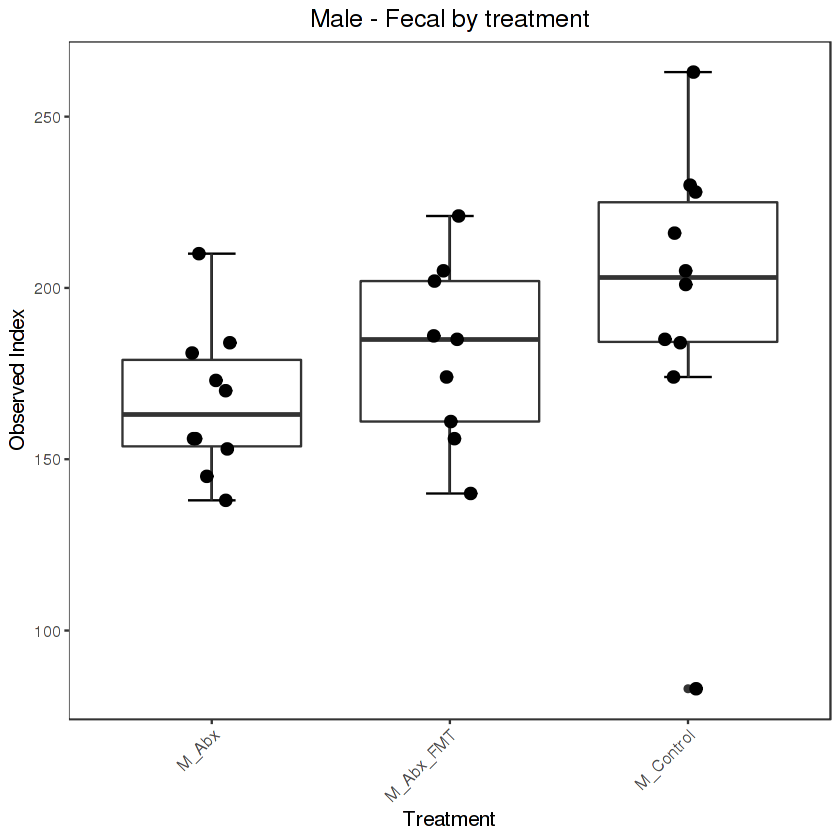

In [20]:
#Observed richness by treatment group - MALES - FECAL

obs = estimate_richness(na.omit(alz_nt_fec_M), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("Treatment") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("Treatment")

stats.obs = dfobs %>%
    group_by(Treatment) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) #%>%
    #arrange(-desc(mean))
stats.obs

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Observed~Treatment, data=dfobs)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfobs$Observed, g=dfobs$Treatment, method="bonferroni")
dunn

#Plot
p = ggplot(na.omit(dfobs), aes(x = Treatment, y = Observed)) + ggtitle("Male - Fecal by treatment")

p = p + stat_boxplot(geom = "errorbar", width = 0.2)+ geom_boxplot(lwd=.5) + ylab("Observed Index")

p = p + geom_point(size = 2,alpha=1,stroke=1,
                   position = position_jitter(h = 0, w = 0.1))#, aes(color=,shape=Organ))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

Treatment,median,mean,sd,sem
M_Abx,3.736119,3.742036,0.2182130,0.06900502
M_Abx_FMT,3.726856,3.567437,0.2657537,0.08858457
M_Control,3.668383,3.800824,0.4051074,0.12810620



	Kruskal-Wallis rank sum test

data:  Shannon by Treatment
Kruskal-Wallis chi-squared = 1.9027, df = 2, p-value = 0.3862


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 1.9027, df = 2, p-value = 0.39


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      M_Abx   M_Abx_FM
---------+----------------------
M_Abx_FM |   1.283723
         |     0.2989
         |
M_Contro |   0.183829  -1.104797
         |     1.0000     0.4039

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 1.902682

$Z
[1]  1.283723  0.183829 -1.104797

$P
[1] 0.09961942 0.42707380 0.13462375

$P.adjusted
[1] 0.2988583 1.0000000 0.4038712

$comparisons
[1] "M_Abx - M_Abx_FMT"     "M_Abx - M_Control"     "M_Abx_FMT - M_Control"

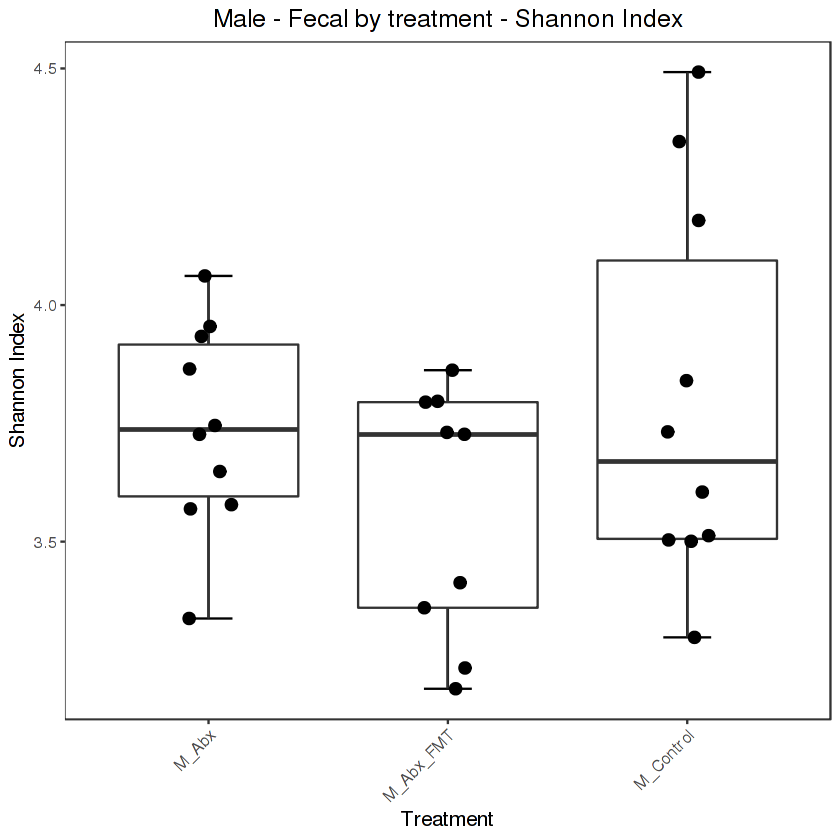

In [25]:
#Shanon Index by treatment group - MALES - FECAL

sha = estimate_richness(na.omit(alz_nt_fec_M), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = merge(sha, sample_tab, on="SampleID")

ordsha = sha %>% group_by("Treatment") %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("Treatment")

stats.sha = dfsha %>%
    group_by(Treatment) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) #%>%
    #arrange(-desc(mean))
stats.sha

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Shannon~Treatment, data=dfsha)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfsha$Shannon, g=dfsha$Treatment, method="bonferroni")
dunn

#Plot
p = ggplot(na.omit(dfsha), aes(x = Treatment, y = Shannon)) + ggtitle("Male - Fecal by treatment - Shannon Index")

p = p + stat_boxplot(geom = "errorbar", width = 0.2)+ geom_boxplot(lwd=.5) + ylab("Shannon Index") #+ ylim(0,250)

p = p + geom_point(size = 2,alpha=1,stroke=1,
                   position = position_jitter(h = 0, w = 0.1))#, aes(color=,shape=Organ))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

### FEMALE FECAL

Treatment,median,mean,sd,sem
F_Abx,141,143.6667,40.42586,13.47529
F_Control,203,199.9000,41.60248,13.15586



	Kruskal-Wallis rank sum test

data:  Observed by Treatment
Kruskal-Wallis chi-squared = 6.4123, df = 1, p-value = 0.01133


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 6.4123, df = 1, p-value = 0.01


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      F_Abx
---------+-----------
F_Contro |  -2.532250
         |    0.0057*

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 6.412291

$Z
[1] -2.53225

$P
[1] 0.005666653

$P.adjusted
[1] 0.005666653

$comparisons
[1] "F_Abx - F_Control"

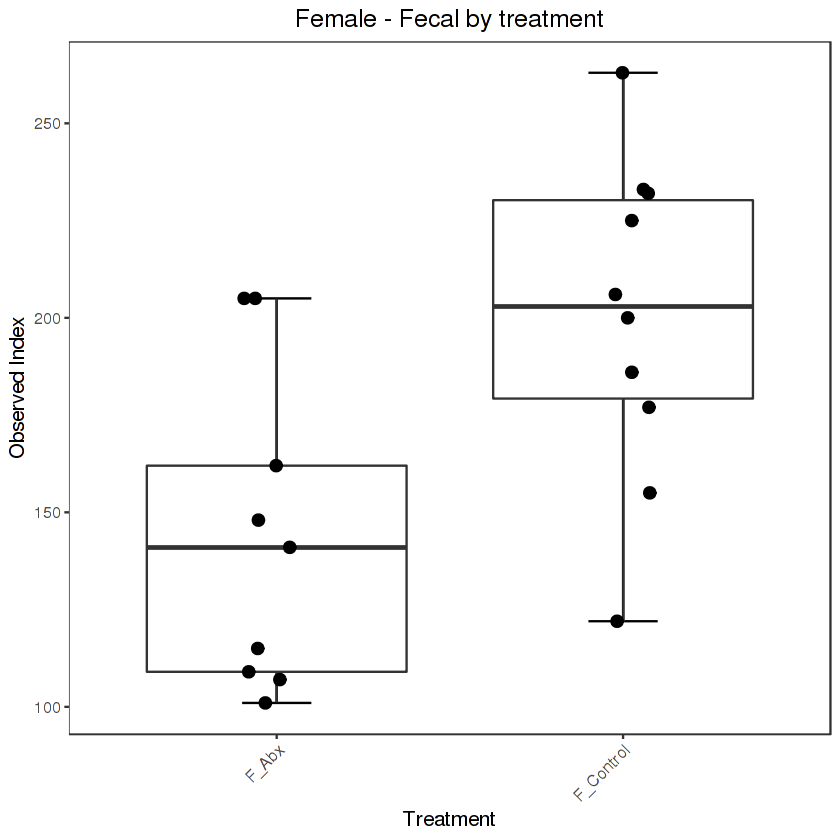

In [21]:
#Observed richness by treatment group - FEMALES - FECAL

obs = estimate_richness(na.omit(alz_nt_fec_F), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("Treatment") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("Treatment")

stats.obs = dfobs %>%
    group_by(Treatment) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) #%>%
    #arrange(-desc(mean))
stats.obs

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Observed~Treatment, data=dfobs)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfobs$Observed, g=dfobs$Treatment, method="bonferroni")
dunn

#Plot
p = ggplot(na.omit(dfobs), aes(x = Treatment, y = Observed)) + ggtitle("Female - Fecal by treatment")

p = p + stat_boxplot(geom = "errorbar", width = 0.2)+ geom_boxplot(lwd=.5) + ylab("Observed Index")

p = p + geom_point(size = 2,alpha=1,stroke=1,
                   position = position_jitter(h = 0, w = 0.1))#, aes(color=,shape=Organ))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

Treatment,median,mean,sd,sem
F_Abx,3.524927,3.671012,0.3272313,0.1090771
F_Control,3.762176,3.864489,0.3151918,0.0996724



	Kruskal-Wallis rank sum test

data:  Shannon by Treatment
Kruskal-Wallis chi-squared = 1.9267, df = 1, p-value = 0.1651


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 1.9267, df = 1, p-value = 0.17


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      F_Abx
---------+-----------
F_Contro |  -1.388044
         |     0.0826

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 1.926667

$Z
[1] -1.388044

$P
[1] 0.0825618

$P.adjusted
[1] 0.0825618

$comparisons
[1] "F_Abx - F_Control"

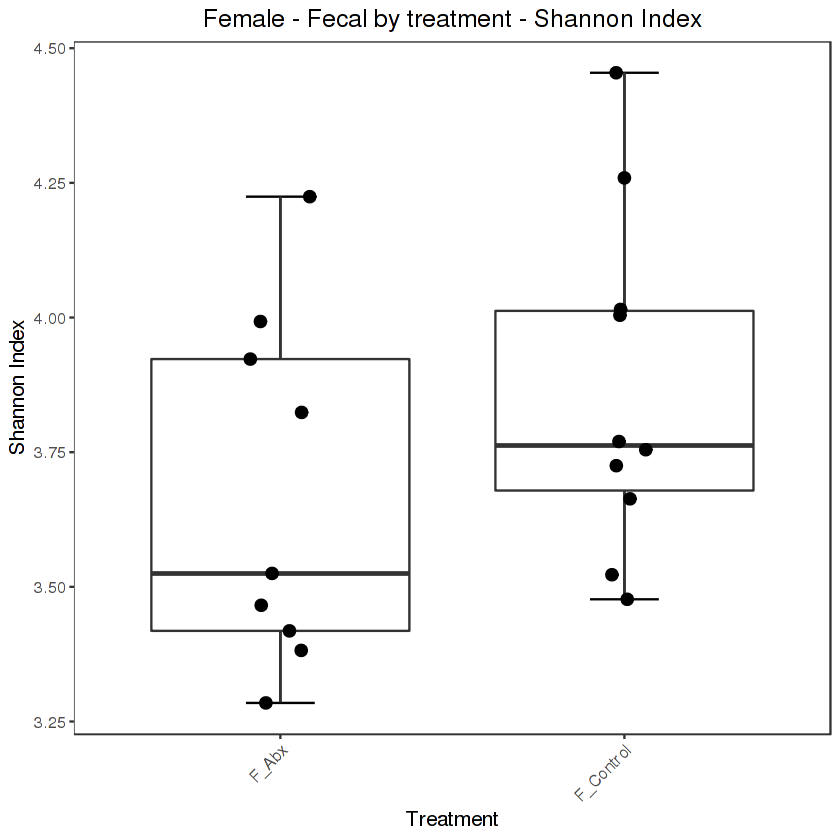

In [22]:
#Shanon Index by treatment group - MALES - FECAL

sha = estimate_richness(na.omit(alz_nt_fec_F), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = merge(sha, sample_tab, on="SampleID")

ordsha = sha %>% group_by("Treatment") %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("Treatment")

stats.sha = dfsha %>%
    group_by(Treatment) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) #%>%
    #arrange(-desc(mean))
stats.sha

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Shannon~Treatment, data=dfsha)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfsha$Shannon, g=dfsha$Treatment, method="bonferroni")
dunn

#Plot
p = ggplot(na.omit(dfsha), aes(x = Treatment, y = Shannon)) + ggtitle("Female - Fecal by treatment - Shannon Index")

p = p + stat_boxplot(geom = "errorbar", width = 0.2)+ geom_boxplot(lwd=.5) + ylab("Shannon Index") #+ ylim(0,250)

p = p + geom_point(size = 2,alpha=1,stroke=1,
                   position = position_jitter(h = 0, w = 0.1))#, aes(color=,shape=Organ))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

### FEMALE CECAL

Treatment,median,mean,sd,sem
F_Abx,108.0,118.875,43.66901,15.43933
F_Control,229.5,230.500,37.21783,11.76931



	Kruskal-Wallis rank sum test

data:  Observed by Treatment
Kruskal-Wallis chi-squared = 10.853, df = 1, p-value = 0.0009865


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 10.8527, df = 1, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      F_Abx
---------+-----------
F_Contro |  -3.294342
         |    0.0005*

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 10.85269

$Z
[1] -3.294343

$P
[1] 0.0004932606

$P.adjusted
[1] 0.0004932606

$comparisons
[1] "F_Abx - F_Control"

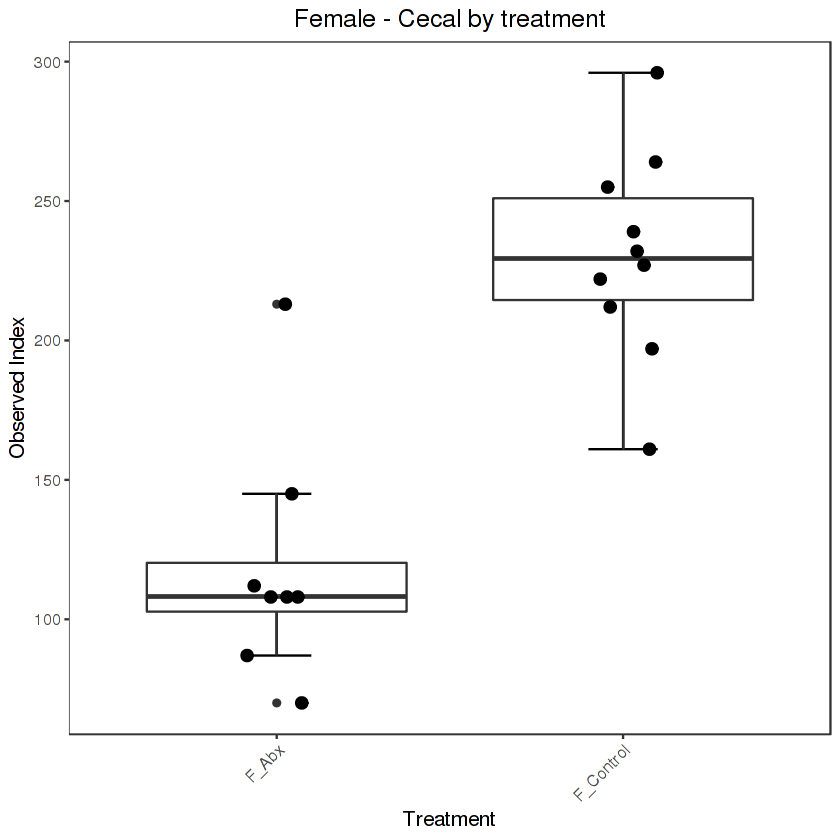

In [23]:
#Observed richness by treatment group - FEMALES - CECAL

obs = estimate_richness(na.omit(alz_nt_cec_F), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("Treatment") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("Treatment")

stats.obs = dfobs %>%
    group_by(Treatment) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) #%>%
    #arrange(-desc(mean))
stats.obs

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Observed~Treatment, data=dfobs)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfobs$Observed, g=dfobs$Treatment, method="bonferroni")
dunn

#Plot
p = ggplot(na.omit(dfobs), aes(x = Treatment, y = Observed)) + ggtitle("Female - Cecal by treatment")

p = p + stat_boxplot(geom = "errorbar", width = 0.2)+ geom_boxplot(lwd=.5) + ylab("Observed Index")

p = p + geom_point(size = 2,alpha=1,stroke=1,
                   position = position_jitter(h = 0, w = 0.1))#, aes(color=,shape=Organ))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

Treatment,median,mean,sd,sem
F_Abx,3.552092,3.352493,0.4709796,0.1665164
F_Control,3.989772,3.947161,0.3168112,0.1001845



	Kruskal-Wallis rank sum test

data:  Shannon by Treatment
Kruskal-Wallis chi-squared = 8.5974, df = 1, p-value = 0.003366


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 8.5974, df = 1, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      F_Abx
---------+-----------
F_Contro |  -2.932126
         |    0.0017*

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 8.597368

$Z
[1] -2.932127

$P
[1] 0.001683246

$P.adjusted
[1] 0.001683246

$comparisons
[1] "F_Abx - F_Control"

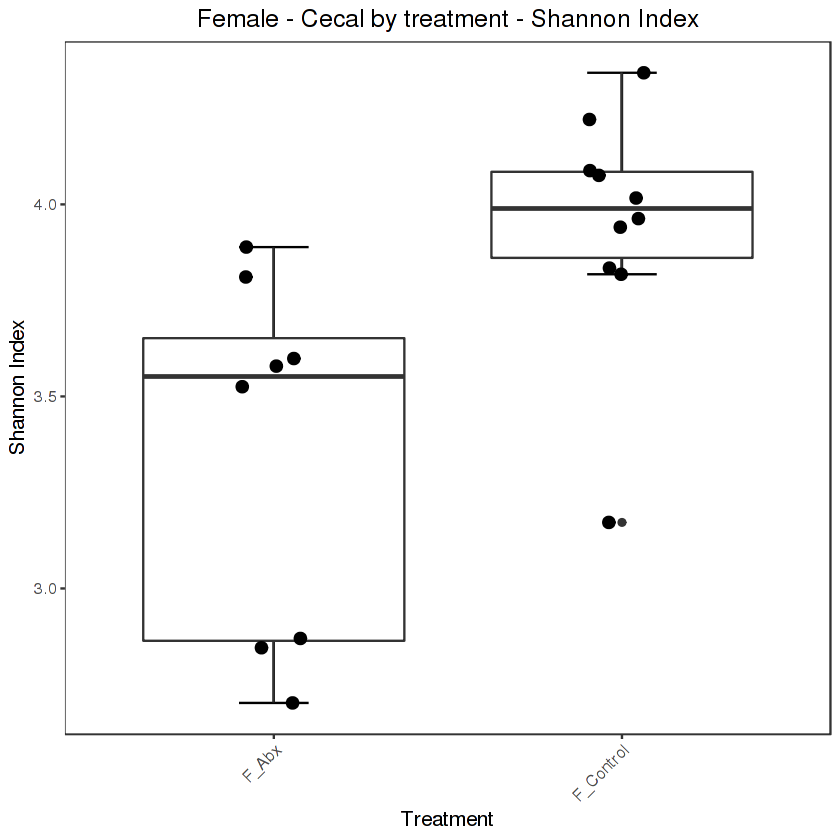

In [24]:
#Shanon Index by treatment group - FEMALES - CECAL

sha = estimate_richness(na.omit(alz_nt_cec_F), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = merge(sha, sample_tab, on="SampleID")

ordsha = sha %>% group_by("Treatment") %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("Treatment")

stats.sha = dfsha %>%
    group_by(Treatment) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) #%>%
    #arrange(-desc(mean))
stats.sha

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Shannon~Treatment, data=dfsha)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfsha$Shannon, g=dfsha$Treatment, method="bonferroni")
dunn

#Plot
p = ggplot(na.omit(dfsha), aes(x = Treatment, y = Shannon)) + ggtitle("Female - Cecal by treatment - Shannon Index")

p = p + stat_boxplot(geom = "errorbar", width = 0.2)+ geom_boxplot(lwd=.5) + ylab("Shannon Index") #+ ylim(0,250)

p = p + geom_point(size = 2,alpha=1,stroke=1,
                   position = position_jitter(h = 0, w = 0.1))#, aes(color=,shape=Organ))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

### MALE CECAL

In [8]:
#Observed richness by treatment group - MALES - CECAL

obs = estimate_richness(na.omit(alz_nt_cec_M), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("Treatment") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("Treatment")

stats.obs = dfobs %>%
    group_by(Treatment) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) #%>%
    #arrange(-desc(mean))
stats.obs

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Observed~Treatment, data=dfobs)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfobs$Observed, g=dfobs$Treatment, method="bonferroni")
dunn

Treatment,median,mean,sd,sem
M_Abx,139,150.5000,47.72665,15.09249
M_Abx_FMT,158,174.3333,55.82114,18.60705
M_Control,191,191.8000,55.81278,17.64955



	Kruskal-Wallis rank sum test

data:  Observed by Treatment
Kruskal-Wallis chi-squared = 2.9875, df = 2, p-value = 0.2245


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 2.9875, df = 2, p-value = 0.22


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      M_Abx   M_Abx_FM
---------+----------------------
M_Abx_FM |  -0.981494
         |     0.4895
         |
M_Contro |  -1.720538  -0.693154
         |     0.1280     0.7323

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 2.987487

$Z
[1] -0.9814948 -1.7205381 -0.6931540

$P
[1] 0.16317441 0.04266734 0.24410644

$P.adjusted
[1] 0.4895232 0.1280020 0.7323193

$comparisons
[1] "M_Abx - M_Abx_FMT"     "M_Abx - M_Control"     "M_Abx_FMT - M_Control"

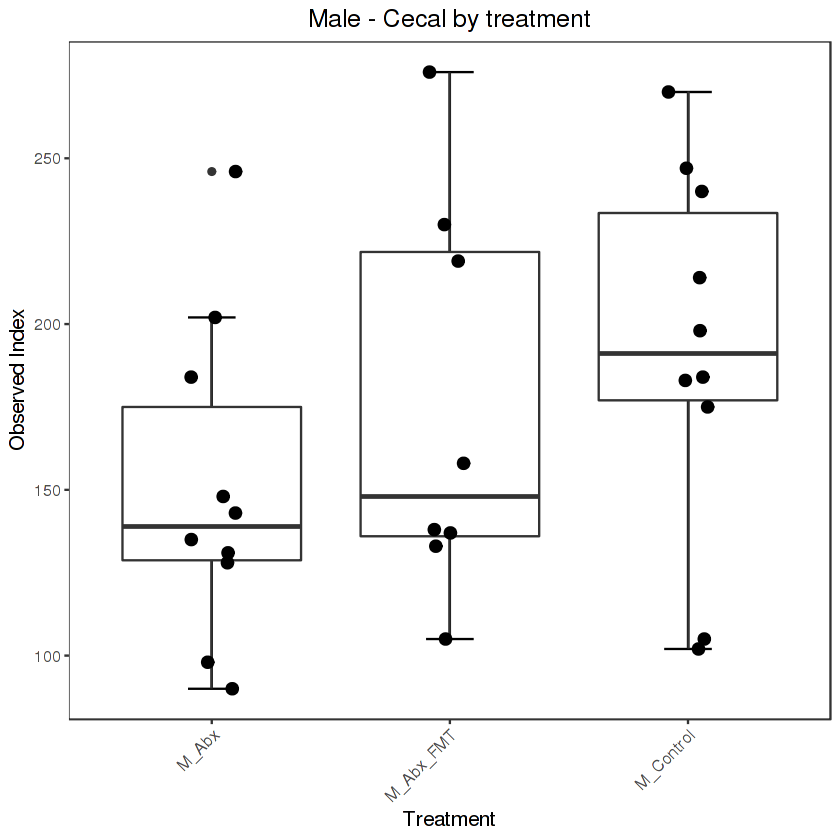

In [13]:
#Plot
p = ggplot(na.omit(dfobs), aes(x = Treatment, y = Observed)) + ggtitle("Male - Cecal by treatment")

p = p + stat_boxplot(geom = "errorbar", width = 0.2)+ geom_boxplot(lwd=.5) + ylab("Observed Index")

p = p + geom_point(size = 2,alpha=1,stroke=1,
                   position = position_jitter(h = 0, w = 0.1))#, aes(color=,shape=Organ))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

In [14]:
#Shanon Index by treatment group - MALES - CECAL

sha = estimate_richness(na.omit(alz_nt_cec_M), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = merge(sha, sample_tab, on="SampleID")

ordsha = sha %>% group_by("Treatment") %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("Treatment")

stats.sha = dfsha %>%
    group_by(Treatment) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) #%>%
    #arrange(-desc(mean))
stats.sha

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Shannon~Treatment, data=dfsha)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfsha$Shannon, g=dfsha$Treatment, method="bonferroni")
dunn

Treatment,median,mean,sd,sem
M_Abx,3.190896,3.259377,0.2855643,0.09030336
M_Abx_FMT,3.146525,3.229104,0.6027147,0.20090489
M_Control,3.505665,3.504035,0.5817431,0.18396332



	Kruskal-Wallis rank sum test

data:  Shannon by Treatment
Kruskal-Wallis chi-squared = 1.3661, df = 2, p-value = 0.5051


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 1.3661, df = 2, p-value = 0.51


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      M_Abx   M_Abx_FM
---------+----------------------
M_Abx_FM |   0.224367
         |     1.0000
         |
M_Contro |  -0.892883  -1.093436
         |     0.5579     0.4113

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 1.36613

$Z
[1]  0.2243675 -0.8928837 -1.0934368

$P
[1] 0.4112357 0.1859597 0.1371010

$P.adjusted
[1] 1.0000000 0.5578792 0.4113031

$comparisons
[1] "M_Abx - M_Abx_FMT"     "M_Abx - M_Control"     "M_Abx_FMT - M_Control"

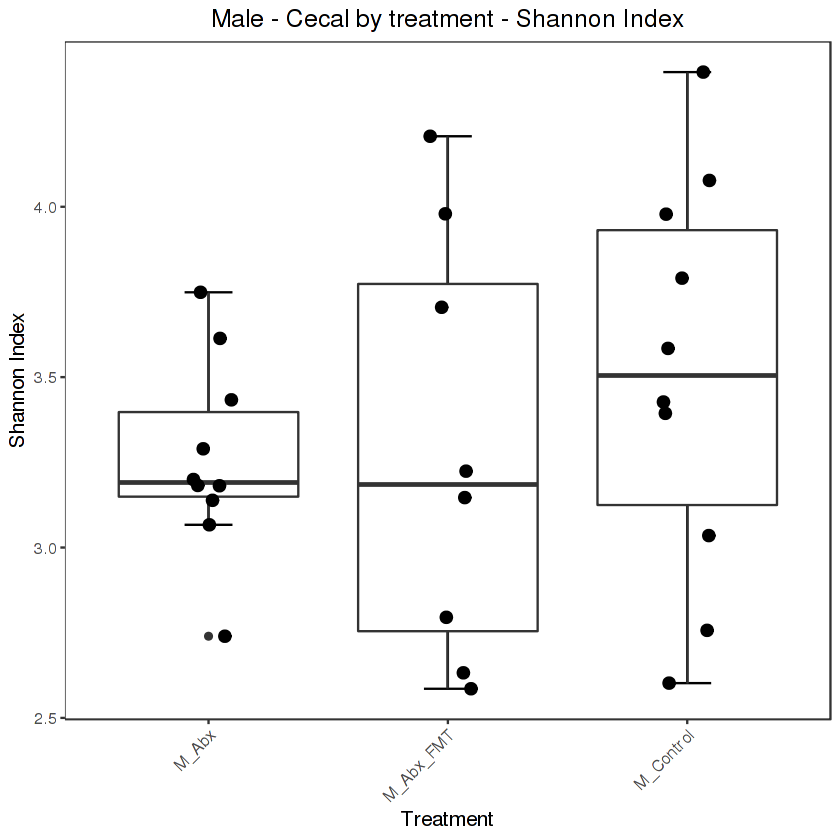

In [15]:
#Plot
p = ggplot(na.omit(dfsha), aes(x = Treatment, y = Shannon)) + ggtitle("Male - Cecal by treatment - Shannon Index")

p = p + stat_boxplot(geom = "errorbar", width = 0.2)+ geom_boxplot(lwd=.5) + ylab("Shannon Index") #+ ylim(0,250)

p = p + geom_point(size = 2,alpha=1,stroke=1,
                   position = position_jitter(h = 0, w = 0.1))#, aes(color=,shape=Organ))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

In [34]:
### Temporary for dplyr functions

In [40]:
head(taxa$otu.names)

[1] 9201a6fe0572e077e734a6500ecb0668 0bf211d89ab72effb2e8a4f129ae60f6
[3] 23ff279fe02e55b89b1d85d366187734 8e39ea92ca6182035539631aaceda2c2
[5] 90034abf8f36ff4866ec378466e6a743 7a3309cebb549a55de943c51706f35c7
729 Levels: 0039c2c4cf37d8a02ff11d8200325978 ...

In [36]:
abx_ctl = read.csv("/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/temp_merge_files/abx_ctl.fecal.ancom.csv")
abx_fmt = read.csv("/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/temp_merge_files/abx_fmt.fecal.ancom.csv")
ctl_fmt = read.csv("/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/temp_merge_files/ctl_fmt.fecal.ancom.csv")
taxa = read.csv("/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/temp_merge_files/alz_nt_taxa.table.csv")

abx_ctl.tax.ancom.csv = left_join(abx_ctl,taxa)
abx_fmt.tax.ancom.csv = left_join(abx_fmt,taxa)
ctl_fmt.tax.ancom.csv = left_join(ctl_fmt,taxa)

write.csv(abx_ctl.tax.ancom.csv, "/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/temp_merge_files/abx_ctl.tax.ancom.csv")
write.csv(abx_fmt.tax.ancom.csv, "/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/temp_merge_files/abx_fmt.tax.ancom.csv")
write.csv(ctl_fmt.tax.ancom.csv, "/gpfs/data/gilbert-lab/Lutz/Alzheimers/Update_Oct2019/ANCOM/results/temp_merge_files/ctl_fmt.tax.ancom.csv")



Joining, by = "otu.names"
Warning message:
“Column `otu.names` joining factors with different levels, coercing to character vector”Joining, by = "otu.names"
Warning message:
“Column `otu.names` joining factors with different levels, coercing to character vector”Joining, by = "otu.names"
Warning message:
“Column `otu.names` joining factors with different levels, coercing to character vector”